# Modeling SDSS-ACT Offset Distribution

Essentially, this is an abridged version of `HSC_ACT_Offset_Distribution.ipynb`.

In [1]:
## Import packages
import numpy as np
from scipy.optimize import minimize
from scipy import integrate

from astropy.io import fits, ascii
from astropy import units as u

from astropy.coordinates import angles
from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy.cosmology import LambdaCDM
from astropy.table import Table
from astropy.visualization import quantity_support
quantity_support()

import matplotlib.pyplot as plt

# Load in catalogs

## ACT Catalog

In [4]:
ACT_cat = Table.read('DR5_cluster-catalog_v1.1.fits', hdu = 1)

column = np.asarray(ACT_cat['decDeg'])
print(f'There are {len(column)} ACT clusters.')

There are 4195 ACT clusters.


## SDSS Catalog

In [5]:
SDSS_cat = Table.read('SDSS_cluster_cat_DR8.fit', hdu = 1)

column = np.asarray(SDSS_cat['ID'])
print(f'There are {len(column)} SDSS clusters.')

There are 25325 SDSS clusters.


## Create SkyCoords

In [14]:
## SkyCoord objects for ACT and SDSS (J2000)
ACT_coords = SkyCoord(ra=ACT_cat['RADeg'] * u.degree, 
                      dec=ACT_cat['decDeg'] * u.degree, 
                      frame='icrs')
SDSS_coords = SkyCoord(ra=SDSS_cat['RAJ2000'], 
                      dec=SDSS_cat['DEJ2000'], 
                      frame='icrs')

# convert coords to (-pi, pi) radians
act_ra = ACT_coords.ra.wrap_at(180 * u.deg).radian
act_dec = ACT_coords.dec.radian
sdss_ra = SDSS_coords.ra.wrap_at(180 * u.deg).radian
sdss_dec = SDSS_coords.dec.radian

# Cross-Match Catalogs

In [23]:
temp = SDSS_cat['zlambda']
print(f'z min: {min(temp)}')
print(f'z max: {max(temp)}')

z min: 0.0802
z max: 0.55


In [17]:
def get_physical_sep(cosmo, theta, z):
    '''
    
    For two objects at the same redshift, calculate their physical separation 
    R as R = theta * d_A, where theta is angular separation (in radians) and 
    d_A is angular distance.
    
    ARGUMENTS
    ----------
    cosmo: model for cosmology; e.g. astropy.cosmology.LambdaCDM(...)
    theta: angular separation; should be a Quantity 
    z: redshift
    
    '''
    
    theta = theta.to(u.rad) / u.rad
    return theta * cosmo.angular_diameter_distance(z)

In [44]:
# idx (length=4195) indexes into SDSS_coords
idx, d2d, d3d = ACT_coords.match_to_catalog_sky(SDSS_coords)

## Calculate physical offsets
h = 0.7
cosmo = LambdaCDM(H0=100*h, Om0=0.3, Ode0=0.7)

angular_sep = ACT_coords.separation(SDSS_coords[idx])
# ACT_redshifts = ACT_cat['redshift']
SDSS_redshifts = SDSS_cat['zlambda']
physical_sep = get_physical_sep(cosmo, angular_sep, SDSS_redshifts[idx])

# impose upper limit on offsets
limit = 1 * u.Mpc / h

def remove_duplicates(idx, d2d, d3d):
    '''
    This function aims to remove duplicates from the results of an 
    asymmetric cross-match.
    
    Given idx, d2d, and d3d from astropy's match_to_catalog_sky function,
    return the 'good' indices in idx as a boolean array. (Here, 'bad' means
    that an index in idx is matched to an object that already has a better 
    match in idx.)
    
    For example: if idx = (8, 8, 8) and d2d = (0.1, 0.3, 0.04), then we 
    accept the third element in idx and reject the two others. This 
    function then returns (False, False, True). 
    
    ARGUMENTS
    ---------
    idx, d2d, d3d: returns of astropy's match_to_catalog_sky function
    
    '''
    
    unique_idx, counts = np.unique(idx, return_counts=True)
    repeated_idxs = unique_idx[np.where(counts > 1)] # idxs appearing in idx multiple times
    not_duplicate = np.ones(idx.shape)
        
    for rep_idx in repeated_idxs:
        locs = np.where(idx == rep_idx)[0] # rep_idx's locations in idx (n=4195)
        locs = locs[physical_sep[locs] < limit] # remove matches whose offsets are too large
        if len(locs) < 2: continue
        best_loc = locs[0]
        
        for loc in locs:
            if d2d[loc] < d2d[best_loc]: best_loc = loc
        for loc in locs:        
            if loc != best_loc: not_duplicate[loc] = 0
            print(f'Cluster matched with SDSS idx {rep_idx} (d2d = {np.round(d2d[loc],3)}):')
            print(ACT_cat[loc]['name'])
            print(f'ACT index (ie loc in idx): {loc}')

        print()
    
    return not_duplicate == 1

In [45]:
print('List of duplicates:')
not_duplicate = remove_duplicates(idx, d2d, d3d)
has_warning = (ACT_cat['warnings'] != '')
within_radius = (physical_sep < limit)
in_crossmatch = not_duplicate & ~has_warning & within_radius
offsets_Mpc = physical_sep[in_crossmatch] # takes subset of all 4195 offsets

print(f'Number of ACT clusters within the preliminary matching radius: {np.sum(within_radius)}')
print(f'Size of final sample: {np.sum(in_crossmatch)}')

List of duplicates:
Cluster matched with SDSS idx 3 (d2d = 0.118 deg):
ACT-CL J0908.8+1102
ACT index (ie loc in idx): 2035
Cluster matched with SDSS idx 3 (d2d = 0.003 deg):
ACT-CL J0909.2+1058
ACT index (ie loc in idx): 2037

Cluster matched with SDSS idx 42 (d2d = 0.089 deg):
ACT-CL J1233.9+1511
ACT index (ie loc in idx): 2551
Cluster matched with SDSS idx 42 (d2d = 0.007 deg):
ACT-CL J1234.2+1515
ACT index (ie loc in idx): 2553

Cluster matched with SDSS idx 52 (d2d = 0.075 deg):
ACT-CL J1326.8+0216
ACT index (ie loc in idx): 2725
Cluster matched with SDSS idx 52 (d2d = 0.003 deg):
ACT-CL J1327.0+0212
ACT index (ie loc in idx): 2726

Cluster matched with SDSS idx 202 (d2d = 0.062 deg):
ACT-CL J2343.7+0016
ACT index (ie loc in idx): 4098
Cluster matched with SDSS idx 202 (d2d = 0.038 deg):
ACT-CL J2343.7+0018
ACT index (ie loc in idx): 4099

Cluster matched with SDSS idx 248 (d2d = 0.018 deg):
ACT-CL J0810.3+1816
ACT index (ie loc in idx): 1923
Cluster matched with SDSS idx 248 (d2d 

# Modeling offset distribution (ACT-SDSS)

See `HSC_ACT_Offset_Distribution.ipynb` for more information on these functions.

In [27]:
use_fixed_sig1 = True

def prob_dens_well_centered(x, sigma1):
    '''
    A model for the offset distribution for well-centered clusters. See
    the documentation for offset_model for a description.
    
    
    ARGUMENTS
    ---------
    x: physical offset
    sigma1: characteristic offset for well-centered clusters
    
    '''
    
    return (x / sigma1**2) * np.exp(-x**2 / (2*sigma1**2))

def prob_dens_mis_centered(x, sigma2):
    '''
    A model for the offset distribution for miscentered clusters. See
    the documentation for offset_model for a description.
    
    ARGUMENTS
    ---------
    x: physical offset
    sigma2: characteristic offset for miscentered clusters
    
    '''
    
    return (x / sigma2**2) * np.exp(-x**2 / (2*sigma2**2))

def offset_model(x, f_cen, sigma1, sigma2):
    '''
    
    A two-component model for the centering offset distribution. Returns 
    the probability density at a given offset. All arguments are in Mpc.
    
    This is equation 9 in the CAMIRA catalog paper (Oguri et al. 2018).
    Both the well-centered population and the miscentered population are
    modeled with a Rayleigh distribution.

    ARGUMENTS
    ---------
    x: physical offset
    f_cen: fraction of well-centered clusters
    sigma1: characteristic offset for well-centered clusters
    sigma2: characteristic offset for miscentered clusters
    
    '''
    
    prob_dens_well = prob_dens_well_centered(x, sigma1)
    prob_dens_mis = prob_dens_mis_centered(x, sigma2)
    
    return f_cen * prob_dens_well + (1 - f_cen) * prob_dens_mis

def offset_model_fixed_sig1(x, f_cen, sigma2, sigma1=0.1):
    '''
    
    Same as offset_model, except sigma1 is a fixed value. 
    All arguments are in Mpc.
    

    ARGUMENTS
    ---------
    x: physical offset
    f_cen: fraction of well-centered clusters
    sigma2: characteristic offset for miscentered clusters
    sigma1: characteristic offset for well-centered clusters; default
    value is 0.1 Mpc
    
    '''
    
    prob_dens_well = prob_dens_well_centered(x, sigma1)
    prob_dens_mis = prob_dens_mis_centered(x, sigma2)
    
    return f_cen * prob_dens_well + (1 - f_cen) * prob_dens_mis

def objective_fn(params, offsets):
    '''
    
    Given the model parameters and the set of offsets, compute
    the objective as a log likelihood.
    
    ARGUMENTS
    ----------
    params: tunable parameters in offset_model
    offsets: set of physical offsets (Mpc; same as offset_model)
    
    '''
    
    f_cen, sig1, sig2 = params
    probs = offset_model(offsets, f_cen, sig1, sig2)
    
    obj = -np.sum(np.log(probs)) # maximizes log likelihood
    return obj

def objective_fn_fixed_sig1(params, offsets, fixed_sig1):
    '''
    
    Given the model parameters and the set of offsets, compute
    the objective as a log likelihood.
    
    ARGUMENTS
    ----------
    params: tunable parameters in offset_model
    offsets: set of physical offsets (Mpc; same as offset_model)
    fixed_sig1: fixed value of sigma1
    
    '''
    
    f_cen, sig2 = params
    probs = offset_model_fixed_sig1(offsets, f_cen, sig2, sigma1=fixed_sig1)
    
    obj = -np.sum(np.log(probs)) # maximizes log likelihood
    return obj

In [46]:
## Fit the model
physical_offsets = offsets_Mpc.value # "offsets" is unitless
sample_size = len(physical_offsets)

if use_fixed_sig1:
    fixed_sig1 = 0.15
    sig1_best = fixed_sig1
    
    initial_guess = (0.75, 0.17)
    best_guess = minimize(fun=objective_fn_fixed_sig1, x0=initial_guess, \
                    args=(physical_offsets, fixed_sig1), method='L-BFGS-B', \
                          bounds=((0., 1), (0.01, 1.)))
    f_best, sig2_best = best_guess.x
else:
    initial_guess = (0.75, 0.03, 0.17)
    best_guess = minimize(fun=objective_fn, x0=initial_guess, args=(physical_offsets), \
                         method='L-BFGS-B', bounds=((0., 1), (1e-4, 0.3), (0.1, 1.)))
    f_best, sig1_best, sig2_best = best_guess.x

print(best_guess)

      fun: -357.21530098693506
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.70530256e-05, -5.68434186e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 10
     njev: 12
   status: 0
  success: True
        x: array([0.81934934, 0.58213376])


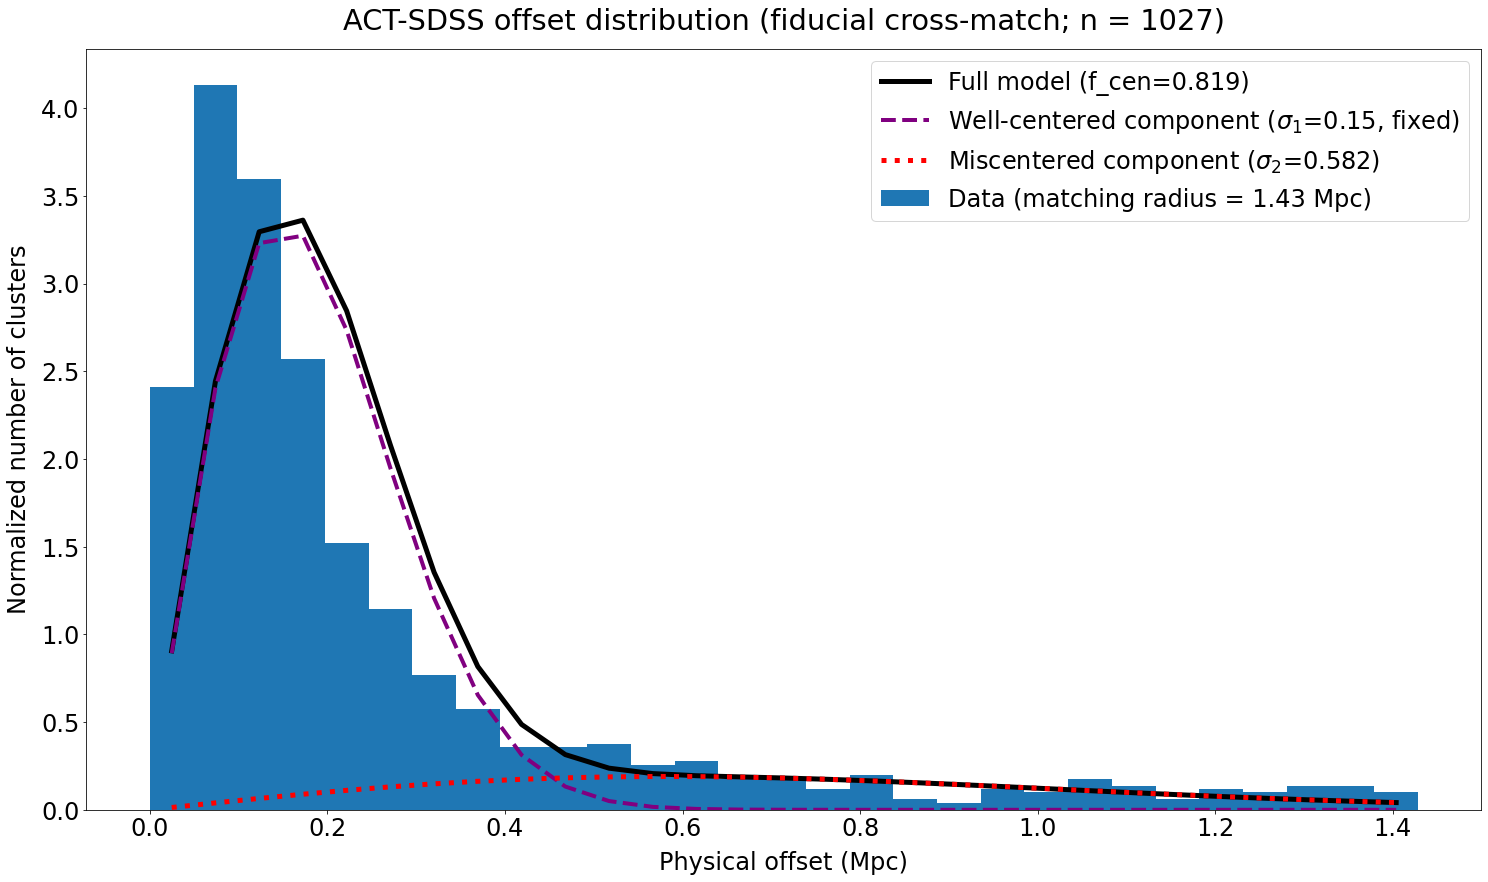

In [47]:
## set global font size
plt.rcParams.update({'font.size':24})

## Plot offset distribution (cross-match)
fig = plt.figure(figsize=(25,14))
fig.patch.set_facecolor('white')

plot_title = f"ACT-SDSS offset distribution (fiducial cross-match; n = {sample_size})"
plt.title(plot_title, pad=20)

## Data sample
num_bins = 30
max_offset = np.max(physical_offsets)
bins = np.linspace(0, max_offset, num=num_bins)
hist = plt.hist(physical_offsets, bins=bins, \
                label=f"Data (matching radius = {np.round(limit,2)})", density=True)
plt.xlabel("Physical offset (Mpc)", labelpad=10)
plt.ylabel("Normalized number of clusters", labelpad=10)

## Model
x_axis = (hist[1][:-1] + hist[1][1:]) / 2 # midpoints of histogram bins
# plot full model
norm_factor_full = 1 / \
        integrate.quad(offset_model, 0, max_offset, args=(f_best, sig1_best, sig2_best))[0]

# plot the full model
plt.plot(x_axis, norm_factor_full*offset_model(x_axis, f_best, sig1_best, sig2_best), \
    label=f"Full model (f_cen={np.round(f_best,3)})", color='black', linewidth=5)

# plot the model's two components separately
if use_fixed_sig1:
    plt.plot(x_axis, norm_factor_full*f_best*prob_dens_well_centered(x_axis, sig1_best),
         label=f"Well-centered component ($\sigma_1$={np.round(sig1_best,3)}, fixed)", \
         color='purple', linestyle='--', linewidth=4)
else:
    plt.plot(x_axis, norm_factor_full*f_best*prob_dens_well_centered(x_axis, sig1_best),
         label=f"Well-centered component ($\sigma_1$={np.round(sig1_best,3)})", \
         color='purple', linestyle='--', linewidth=4)
plt.plot(x_axis, norm_factor_full*(1-f_best)*prob_dens_mis_centered(x_axis, sig2_best), 
         label=f"Miscentered component ($\sigma_2$={np.round(sig2_best,3)})", \
         color='red', linestyle=':', linewidth=5)

plt.legend()
plt.savefig("Figures/Modeling_Offset_Distro/Rayleigh_model/SDSS_crossmatch.png", bbox_inches='tight')
plt.show()